In [ ]:
from desc.integrals import Bounce2D

from desc.examples import get
from desc.grid import LinearGrid
from desc.optimize import Optimizer

from desc.objectives import (
    ForceBalance,
    FixPsi,
    FixBoundaryR,
    FixBoundaryZ,
    GenericObjective,
    FixPressure,
    FixIota,
    AspectRatio,
    EffectiveRipple,
    ObjectiveFunction,
)
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def plot_wells(
    eq,
    grid,
    theta,
    Y_B=None,
    num_transit=3,
    num_well=None,
    num_pitch=10,
):
    """Plotting tool to help user set tighter upper bound on ``num_well``.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium to compute on.
    grid : LinearGrid
        Tensor-product grid in (ρ, θ, ζ) with uniformly spaced nodes
        (θ, ζ) ∈ [0, 2π) × [0, 2π/NFP).
    theta : jnp.ndarray
        Shape (num rho, X, Y).
        DESC coordinates θ sourced from the Clebsch coordinates
        ``FourierChebyshevSeries.nodes(X,Y,rho,domain=(0,2*jnp.pi))``.
        Use the ``Bounce2D.compute_theta`` method to obtain this.
    Y_B : int
        Desired resolution for |B| along field lines to compute bounce points.
        Default is double ``Y``.
    num_transit : int
        Number of toroidal transits to follow field line.
        For axisymmetric devices, one poloidal transit is sufficient. Otherwise,
        assuming the surface is not near rational, more transits will
        approximate surface averages better, with diminishing returns.
    num_well : int
        Maximum number of wells to detect for each pitch and field line.
        Giving ``None`` will detect all wells but due to current limitations in
        JAX this will have worse performance.
        Specifying a number that tightly upper bounds the number of wells will
        increase performance. In general, an upper bound on the number of wells
        per toroidal transit is ``Aι+B`` where ``A``,``B`` are the poloidal and
        toroidal Fourier resolution of |B|, respectively, in straight-field line
        PEST coordinates, and ι is the rotational transform normalized by 2π.
        A tighter upper bound than ``num_well=(Aι+B)*num_transit`` is preferable.
        The ``check_points`` or ``plot`` methods in ``desc.integrals.Bounce2D``
        are useful to select a reasonable value.
    num_pitch: int
        Number of pitch angles.

    Returns
    -------
    plots
        Matplotlib (fig, ax) tuples for the 1D plot of each field line.

    """
    data = eq.compute(Bounce2D.required_names + ["min_tz |B|", "max_tz |B|"], grid=grid)
    bounce = Bounce2D(grid, data, theta, Y_B, num_transit)
    pitch_inv, _ = Bounce2D.get_pitch_inv_quad(
        grid.compress(data["min_tz |B|"]),
        grid.compress(data["max_tz |B|"]),
        num_pitch,
    )
    points = bounce.points(pitch_inv, num_well=num_well)
    plots = bounce.check_points(points, pitch_inv)
    return plots

## Plotting field lines

In [3]:
# ---------- Precise QH ----------
# Computing at higher resolution than necessary.
eq0 = get("precise_QH")
rho = np.linspace(0.01, 1, 10)
grid = LinearGrid(rho=rho, M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, sym=False)
X, Y = 32, 64
theta = Bounce2D.compute_theta(eq0, X, Y, rho=rho)

# ---------- How to pick resolution? ----------
num_transit = 3
# Running below at few different settings, we observe Y_B = 100 sufficient,
# and see about 3 wells per toroidal transit.
plot_wells(
    eq0,
    grid,
    theta,
    # Plotting for 3 toroidal transits to see by eye
    # if Y_B is high enough that |B|(ζ) doesn't change as Y_B is varied.
    Y_B=100,
    num_transit=num_transit,
    # Plot the field lines to obtain a tight upper bound on ``num_well``.
    num_well=15 * num_transit,
);

## Calculating effective ripple for Precise QH

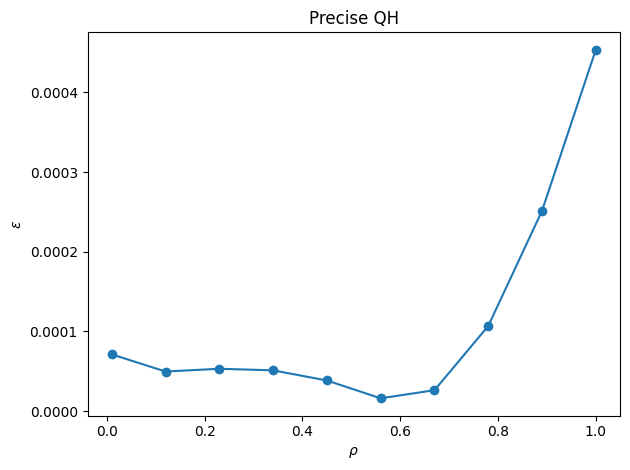

In [4]:
num_transit = 20
num_well = 10 * num_transit
num_pitch = 45
data = eq0.compute(
    "effective ripple",
    grid=grid,
    theta=theta,
    Y_B=100,
    num_transit=num_transit,
    # Optional; improves performance if num well < Y_B * num transit.
    num_well=num_well,
    # number of quadrature points for each bounce integral
    num_quad=32,
    # number of pitch angles for integration over velocity coordinate
    num_pitch=num_pitch,
    # number of pitch angles to compute simultaneously.
    # Reduce this if insufficient memory. If insufficient memory is detected
    # early then the code will exit and return ε = 0 everywhere. If not detected
    # early then typical OOM errors will occur.
    batch_size=None,
)

eps_32 = grid.compress(data["effective ripple"])
fig, ax = plt.subplots()
ax.plot(rho, eps_32, marker="o")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Precise QH")
plt.tight_layout()
plt.show()

## Calculating effective ripple for Heliotron

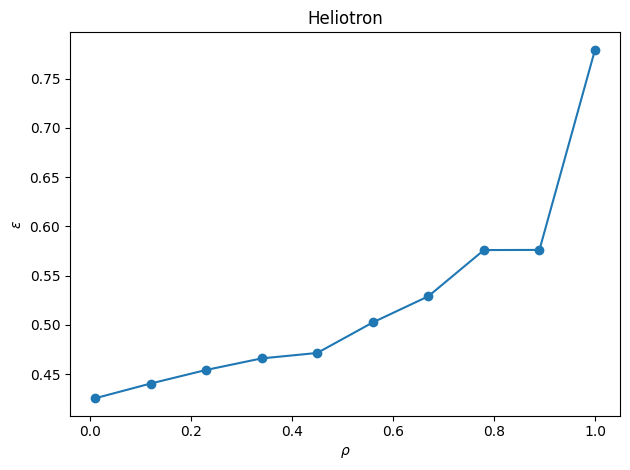

In [5]:
eq0 = get("HELIOTRON")
grid = LinearGrid(rho=rho, M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, sym=False)
Y_B = 150
num_transit = 20
num_well = 30 * num_transit
num_quad = 64
data = eq0.compute(
    "effective ripple",
    grid=grid,
    theta=Bounce2D.compute_theta(eq0, X, Y, rho=rho),
    Y_B=Y_B,
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
)

eps_32 = grid.compress(data["effective ripple"])
fig, ax = plt.subplots()
ax.plot(rho, eps_32, marker="o")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Heliotron")
plt.tight_layout()
plt.show()

## Optimizing Heliotron

In [6]:
eq1 = eq0.copy()
k = 2  # which modes to unfix
print()
print("---------------------------------------")
print(f"Optimizing boundary modes M, N <= {k}")
print("---------------------------------------")
modes_R = np.vstack(
    (
        [0, 0, 0],
        eq1.surface.R_basis.modes[np.max(np.abs(eq1.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq1.surface.Z_basis.modes[np.max(np.abs(eq1.surface.Z_basis.modes), 1) > k, :]
constraints = (
    ForceBalance(eq=eq1),
    FixBoundaryR(eq=eq1, modes=modes_R),
    FixBoundaryZ(eq=eq1, modes=modes_Z),
    FixPressure(eq=eq1),
    FixIota(eq=eq1),
    FixPsi(eq=eq1),
)
curvature_grid = LinearGrid(
    rho=np.array([1.0]), M=eq1.M_grid, N=eq1.N_grid, NFP=eq1.NFP, sym=eq1.sym
)
ripple_grid = LinearGrid(
    rho=np.linspace(0.2, 1, 5), M=eq1.M_grid, N=eq1.N_grid, NFP=eq1.NFP, sym=False
)
objective = ObjectiveFunction(
    (
        EffectiveRipple(
            eq1,
            grid=ripple_grid,
            X=16,
            Y=32,
            Y_B=128,
            num_transit=10,
            num_well=30 * 10,
            num_quad=32,
            num_pitch=45,
            # TODO: It seems batch_size has no effect on memory consumed by Jacobian in reverse mode.
            batch_size=1,
            deriv_mode="fwd",
        ),
        AspectRatio(eq1, bounds=(8, 11), weight=1e3),
        GenericObjective(
            "curvature_k2_rho", eq1, grid=curvature_grid, bounds=(-128, 10), weight=2e3
        ),
    )
)
optimizer = Optimizer("proximal-lsq-exact")
(eq1,), _ = optimizer.optimize(
    eq1,
    objective,
    constraints,
    ftol=1e-4,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=5,  # increase maxiter to 50 for a better result
    verbose=3,
    options={"initial_trust_ratio": 2e-3},
)
print("Optimization complete!")


---------------------------------------
Optimizing boundary modes M, N <= 2
---------------------------------------
Building objective: Effective ripple
Precomputing transforms
Timer: Precomputing transforms = 928 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 67.8 ms
Building objective: generic
Timer: Objective build = 2.29 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 579 ms
Timer: Objective build = 1.06 sec
Timer: Proximal projection build = 9.95 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 544 ms
Timer: Linear constraint projection build = 2.67 sec
Number of parameters: 24
Number of objectives: 253
Timer: Initializing the optimization = 13.2 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    S

In [7]:
data = eq1.compute(
    "effective ripple",
    grid=grid,
    theta=Bounce2D.compute_theta(eq1, X, Y, rho=rho),
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
)
eps_32_opt = grid.compress(data["effective ripple"])

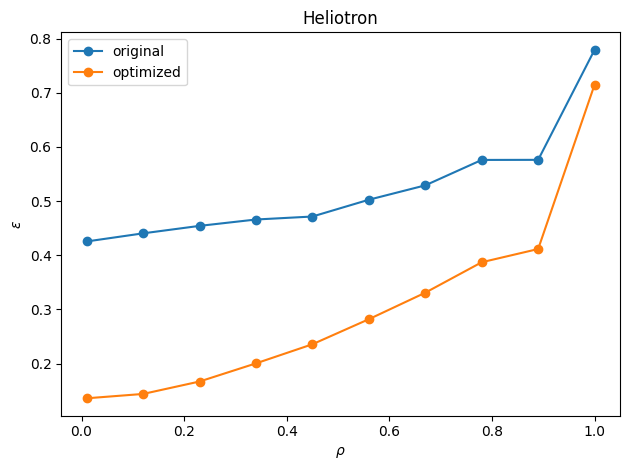

In [8]:
fig, ax = plt.subplots()
ax.plot(rho, eps_32, marker="o", label="original")
ax.plot(rho, eps_32_opt, marker="o", label="optimized")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Heliotron")
ax.legend()
plt.tight_layout()
plt.show()